<a href="https://colab.research.google.com/github/shiernee/Advanced_ML/blob/main/Week12/WOA7015_Wk12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to WOA7015 Advance Machine Learning Lab - Week 12
This code is generated for the purpose of WOA7015 module.
The code is available in github https://github.com/shiernee/Advanced_ML 


In this class, we will go through some case study that use machine learning to solve real-life problem. 



## Example: Predicting Bicycle Traffic

As an example, let's take a look at whether we can **predict the number of bicycle trips across Seattle's Fremont Bridge based on weather, season, and other factors.**

In this section, we will join the bike data with another dataset, and try to determine the extent to which weather and seasonal factors—temperature, precipitation, and daylight hours—affect the volume of bicycle traffic through this corridor.

Fortunately, the NOAA makes available their daily [weather station data](http://www.ncdc.noaa.gov/cdo-web/search?datasetid=GHCND) (I used station ID USW00024233) and we can easily use Pandas to join the two data sources.
We will perform a simple linear regression to relate weather and other information to bicycle counts, in order to estimate how a change in any one of these parameters affects the number of riders on a given day.

In particular, this is an example of how the tools of Scikit-Learn can be used in a statistical modeling framework, in which the parameters of the model are assumed to have interpretable meaning.

As discussed previously, this is not a standard approach within machine learning, but such interpretation is possible for some models.

Let's start by loading the two datasets, indexing by date:

## Section 1: Modeling with Linear Regression 

In [1]:
!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4585k    0 4585k    0     0  1205k      0 --:--:--  0:00:03 --:--:-- 1204k


In [2]:
import pandas as pd
counts = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/master/notebooks/data/BicycleWeather.csv', index_col='DATE', parse_dates=True)

Now we will look at the datasets

In [3]:
# number of bicycle pass through at specific time 
counts.head()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2019-11-01 00:00:00,12.0,7.0,5.0
2019-11-01 01:00:00,7.0,0.0,7.0
2019-11-01 02:00:00,1.0,0.0,1.0
2019-11-01 03:00:00,6.0,6.0,0.0
2019-11-01 04:00:00,6.0,5.0,1.0


Next we will compute the total daily bicycle traffic, and put this in its own dataframe:

In [4]:
daily = counts.resample('d').sum()  # sum up bicycle by day
daily['Total'] = daily['Fremont Bridge Total']
daily = daily[['Total']] # remove other columns

In [5]:
counts.resample('d').sum()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2012-10-03,7042.0,3520.0,3522.0
2012-10-04,6950.0,3416.0,3534.0
2012-10-05,6296.0,3116.0,3180.0
2012-10-06,4012.0,2160.0,1852.0
2012-10-07,4284.0,2382.0,1902.0
...,...,...,...
2021-12-27,74.0,23.0,51.0
2021-12-28,91.0,32.0,59.0
2021-12-29,75.0,32.0,43.0


We hypothesized that the patterns of use generally vary from day to day; let's account for this in our data by adding binary columns that indicate the day of the week:

In [6]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

daily

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
2021-12-27,74.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-28,91.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2021-12-29,75.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Second hypothesis: we might expect riders to behave differently on holidays; let's add an indicator of this as well:

In [7]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)
daily

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
2021-12-27,74.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-28,91.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-12-29,75.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


Third hypothesis: We also might suspect that the hours of daylight would affect how many people ride; let's use the standard astronomical calculation to add this information:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


(8.0, 17.0)

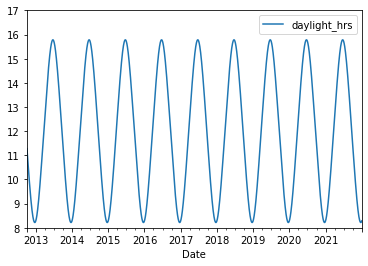

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)

Forth hypothesis: Average temperature and total precipitation will have effect on the traffice. We add this data to the data. In addition to the inches of precipitation, let's add a flag that indicates whether a day is dry (has zero precipitation):

In [9]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])
daily

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day
Date,,,,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,74.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.241450,NaN,NaN,NaN
2021-12-28,91.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.249949,NaN,NaN,NaN
2021-12-29,75.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.259788,NaN,NaN,NaN


Finally, let's add a counter that increases from day 1, and measures how many years have passed. This will let us measure any observed annual increase or decrease in daily crossings:

In [10]:
daily['annual'] = (daily.index - daily.index[0]).days / 365.
daily

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,74.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.241450,NaN,NaN,NaN,9.238356
2021-12-28,91.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.249949,NaN,NaN,NaN,9.241096
2021-12-29,75.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8.259788,NaN,NaN,NaN,9.243836


With this in place, we can choose the columns to use, and fit a linear regression model to our data. We will set fit_intercept = False, because the daily flags essentially operate as their own day-specific intercepts:

In [16]:
from sklearn.linear_model import LinearRegression

# Drop any rows with null values
daily.dropna(axis=0, how='any', inplace=True)

column_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily['predicted'] = model.predict(X)

Finally, we can compare the total and predicted bicycle traffic visually:

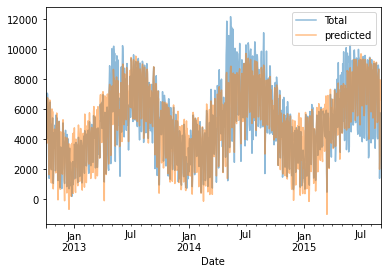

In [17]:
daily[['Total', 'predicted']].plot(alpha=0.5);

It is evident that we have missed some key features, especially during the summer time. Either our features are not complete (i.e., people decide whether to ride to work based on more than just these) or there are some nonlinear relationships that we have failed to take into account (e.g., perhaps people ride less at both high and low temperatures). Nevertheless, our rough approximation is enough to give us some insights, and we can take a look at the coefficients of the linear model to estimate how much each feature contributes to the daily bicycle count:

In [18]:
params = pd.Series(model.coef_, index=X.columns)
params

Mon             1009.765512
Tue             1220.467872
Wed             1185.347283
Thu              964.716230
Fri              355.960691
Sat            -2206.603421
Sun            -2267.134492
holiday        -2374.802762
daylight_hrs     257.703022
PRCP           -1329.669764
dry day         1095.397185
Temp (C)         130.325582
annual            53.885426
dtype: float64

These numbers are difficult to interpret without some measure of their uncertainty. We can compute these uncertainties quickly using bootstrap resamplings of the data:

In [19]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_
              for i in range(1000)], 0)

With these errors estimated, let's again look at the results:

In [20]:
print(pd.DataFrame({'effect': params.round(0),
                    'error': err.round(0)}))

              effect  error
Mon           1010.0  173.0
Tue           1220.0  166.0
Wed           1185.0  166.0
Thu            965.0  170.0
Fri            356.0  162.0
Sat          -2207.0  159.0
Sun          -2267.0  166.0
holiday      -2375.0  326.0
daylight_hrs   258.0   18.0
PRCP         -1330.0  125.0
dry day       1095.0   66.0
Temp (C)       130.0    7.0
annual          54.0   35.0


## Findings
We first see that there is a relatively stable trend in the weekly baseline: there are many more riders on weekdays than on weekends and holidays. 

* We see that for each additional hour of daylight, 258 ± 18 more people choose to ride; 
* A temperature increase of one degree Celsius encourages 130 ± 7 people to grab their bicycle; 
* A dry day means an average of 1096 ± 66 more riders, and 
* each inch of precipitation means 1330 ± 125 more people leave their bike at home. 
* Once all these effects are accounted for, we see a modest increase of 54 ± 25 new daily riders each year.

Our model is almost certainly missing some relevant information. 

For example, nonlinear effects (such as effects of precipitation and cold temperature) and nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temperatures) cannot be accounted for in this model. 

Additionally, we have thrown away some of the finer-grained information (such as the difference between a rainy morning and a rainy afternoon), and we have ignored correlations between days (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days). 

These are all potentially interesting effects, and you now have the tools to begin exploring them if you wish!

## Section 2: Redefine the problem into developing a ML model and evaluate the performance. 

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [22]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mean percentage error:  0.22359561847447249
reg coeff [  965.5128526   1227.46820051  1050.05831048   918.58049811
   344.96235708 -2223.87606314 -2282.70615563 -2142.83694527
   254.99297568 -1398.58183408  1073.00219013   128.30443799
    52.06300632]



Text(0.5, 1.0, 'MAPE')

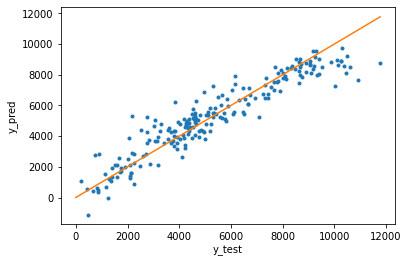

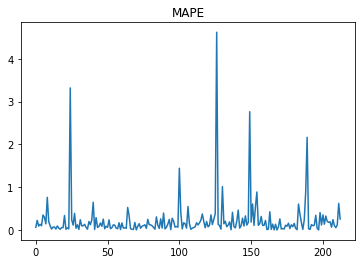

In [23]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

mape = mean_absolute_percentage_error(y_test, y_pred)
print('mean percentage error: ', mape)
print('reg coeff', model.coef_)
print()

plt.plot(y_test, y_pred, '.')
plt.plot(np.arange(max(y_test)), np.arange(max(y_test)), '-')
plt.xlabel('y_test')
plt.ylabel('y_pred')

plt.figure()
plt.plot(np.arange(len(y_test)), abs(y_test-y_pred)/y_test)
plt.title('MAPE')

## Is this reliable??? we can repeat the experiment by doing cross validation and get an average of the model performance


In [24]:
# some tutorial - save the data of every iteration 

ans = []  # create an empty list
for i in range(10):
  ans.append(i)

print(ans)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [ ]:
# some tutorial - get the index row in pandas
import copy
a = copy.copy(X)
print(a)

# get 5th row - get the values. python start from zero
print(a.values[4])

In [ ]:
# get 1-5th row
print(a.values[:5])

## Your turn to try. Write a code to do 5-fold cross validation on linear regression. Compute the MAPE of each iteration.

In [ ]:
# your code here




In [33]:
#@title Solution
import numpy as np

from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
kf.get_n_splits(X)

mape_cv = []
n = 1

print('linear regression model')
for train_index, test_index in kf.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]

    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mape = round((mean_absolute_percentage_error(y_test, y_pred)), 4)
    mape_cv.append(mape)
    n += 1

print('The average MAPE across five fold CV:')
print(np.mean(mape_cv))
print('The stdev MAPE across five fold CV:')
print(np.std(mape_cv))

linear regression model
The average MAPE across five fold CV:
0.20344
The stdev MAPE across five fold CV:
0.04241323378380856


The model has an average performance of 20% +- 4% mean absolute percentage error. [Is it good enough? This has to be check across other studies, are your model better than other? Or can check with domain expert, is this MAPE good enough? ] 

The stdev is 4%, which tells us that the model is quite stable. 

# Acknowledgement
This exercise is inspired from https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.06-Linear-Regression.ipynb#scrollTo=Zhq0qG1N_u3R 